# Proprocessing of input data for Yield-gap analysis

Data sources:  
- EarthStat yield gap data [source](http://www.earthstat.org/yield-gaps-climate-bins-major-crops/)  


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import xarray as xr
from io import StringIO
import re

module_path = Path.cwd().resolve()
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
data_path = Path('data')

In [4]:
# calculate area grid for summary stats
def calc_area(lat, pixeldegree):
    area_km2 = (110.45 * pixeldegree) * (111.1944 * pixeldegree) * math.cos(lat * (math.pi / 180.0))
    area_ha  = area_km2 * 100
    return area_ha

def create_area_grid(da, res=0.1):
    da_area = xr.zeros_like(da)
    da_area.attrs = {'long_name': 'area', 'units': 'ha'}
    da_area.name = 'area'
    for lat in da_area.lat.values:
        da_area.loc[{'lat': lat}] = calc_area(lat, res)
    return da_area

def fix_coords(da, res=0.1):
    """Make sure that float32 and float64 have the exact same coordinates so we can compute with them"""
    ndigits = len(str(res).split('.')[-1])+1
    
    for y, x in [('latitude', 'longitude'),('lat', 'lon'), ('y', 'x')]:
        if (y in list(da.coords)) and (x in list(da.coords)):
            return da.assign_coords({y: da[y].astype('float32').round(ndigits), x: da[x].astype('float32').round(ndigits)})
    raise NotImplementedError

## Yield gap data


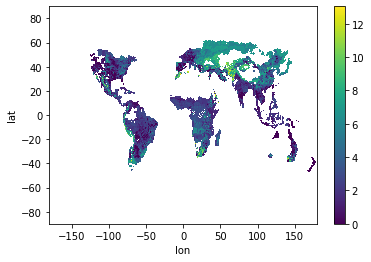

In [5]:
ygap = xr.open_rasterio(data_path / "maize_yieldgap.tif").squeeze(drop=True)
ygap = fix_coords(ygap, res=0.083)
ygap = ygap.where(ygap > -1000)
ygap = ygap.rename({'x': 'lon', 'y': 'lat'})
ygap.plot();

In [6]:
ygap

<xarray.DataArray (lat: 2160, lon: 4320)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 89.9583 89.875 89.7917 ... -89.7917 -89.875 -89.9583
  * lon      (lon) float32 -179.9583 -179.875 -179.7917 ... 179.875 179.9583
Attributes:
    transform:      (0.0833333333333286, 0.0, -180.0, 0.0, -0.083333333333328...
    crs:            +init=epsg:4326
    res:            (0.0833333333333286, 0.0833333333333286)
    is_tiled:       1
    nodatavals:     (-3.402823e+38,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

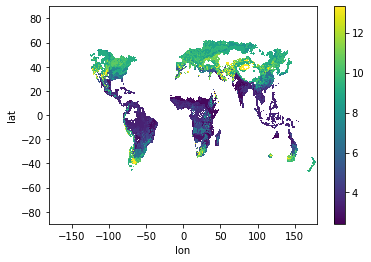

In [7]:
# load bioclimate data (import of resampled geotiff/ source: ArcGIS resampling)
ypot = xr.open_rasterio(data_path / "maize_yieldpotential.tif").squeeze(drop=True)
ypot = fix_coords(ypot, res=0.083)
ypot = ypot.where(ypot > -1000)
ypot = ypot.rename({'x': 'lon', 'y': 'lat'})
ypot.plot();

In [8]:
ypot

<xarray.DataArray (lat: 2160, lon: 4320)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 89.9583 89.875 89.7917 ... -89.7917 -89.875 -89.9583
  * lon      (lon) float32 -179.9583 -179.875 -179.7917 ... 179.875 179.9583
Attributes:
    transform:      (0.0833333333333286, 0.0, -180.0, 0.0, -0.083333333333328...
    crs:            +init=epsg:4326
    res:            (0.0833333333333286, 0.0833333333333286)
    is_tiled:       1
    nodatavals:     (-3.402823e+38,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

In [9]:
# store the rectified data
with xr.Dataset() as dsout:
    dsout['yieldgap'] = ygap.astype('float32')
    dsout['yieldpot'] = ypot.astype('float32')

    # sort latitude to go from net to pos
    dsout = dsout.sortby(dsout.lat)
    dsout.to_netcdf('yielddata_maize_clean.nc')

In [10]:
# load yield data layers again
ygap = (xr.open_dataset("yielddata_maize_clean.nc")['yieldgap']).sel(lat=slice(-50,40), lon=slice(-30, 60))
ypot = (xr.open_dataset("yielddata_maize_clean.nc")['yieldpot']).sel(lat=slice(-50,40), lon=slice(-30, 60))

## Administrative data for summary stats and country mask

In [11]:
with xr.open_dataset(data_path / 'tmworld' / 'tmworld_un_HR.nc') as tm:   
    admin = fix_coords(tm.sel(lat=slice(-50,40), lon=slice(-30, 60)), res=0.083)
    country = admin.rename({'Band1': 'COUNTRY'})
    country.to_netcdf('countries_0083deg.nc')

In [12]:
with xr.open_dataset(data_path / 'tmworld' / 'tmworld_region_HR.nc') as tm:   
    admin = fix_coords(tm.sel(lat=slice(-50,40), lon=slice(-30, 60)), res=0.083)
    admin = admin.rename({'Band1': 'REGION'})
    mask = admin.REGION.where(admin.REGION == 2).notnull()
    mask.to_netcdf('africa_mask_0083deg.nc')

## Cropping seasons/ rotations

In [13]:
def read_asc(fname):
    SIZE = 0.083333333333
    HSIZE =  SIZE * 0.5
    
    with open(fname, 'r') as f:
        lines = f.read().splitlines()
    data = np.array([[int(x) for x in line.split()] for line in lines[5:]]).astype('float')
    lats = np.arange(-35 + HSIZE, -35 + (876*SIZE), SIZE)[::-1]
    lons = np.arange(-18 + HSIZE, -18 + (840*SIZE), SIZE)
    da = xr.DataArray(np.zeros((876, 840), 'float'), coords=[('lat', lats),('lon', lons)], name='rotations')
    data[data==14] = np.nan 
    da[:] = data - 1
    return da

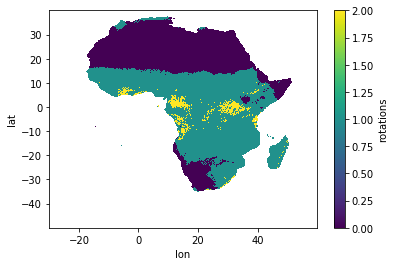

In [14]:
# cropping seasons
rotations = read_asc("data/n_seasons_africa_5m.asc")
rotations = rotations.sortby(rotations.lat).reindex_like(mask, method='nearest', tolerance=0.01)
rotations.plot();

# Create joined dataset

In [15]:
with xr.Dataset() as new:
    new["ygap"] = ygap
    new["ypot"] = ypot
    new["mask"] = mask
    new["ygapm"] = ygap.where(mask == True)
    new["ypotm"] = ypot.where(mask == True)
    new["area"] = create_area_grid(ygap, res=0.0833333333)
    new["rot"] = rotations.where(mask == True)
    new["country"] = country.COUNTRY.where(mask == True)
    new.to_netcdf("yieldgap_analysis_0083deg.nc")

# Extract potential yield for measurement sites

We use the original dataset since the locations are from all over the world...

In [16]:
# coordinates as provided by Sonja (cleaned)
coords= """no	latitude	longitude
1	17° 35' S	31° 14' E
2	0° 6' N	34° 33' E
3	0° 0' N	34° 35' E
4	01° 15' S	36° 46' E
5	17° 42' S	31° 00' E
6	0° 8' N	34° 24' E
7	07° 15' S	37° 48' E
8	00° 47' S	37° 39' E
9	1˚ 05' S	37˚ 0' E
10	0˚ 34' N	34˚ 11' E
11	0˚ 08' N	34˚ 25' E
12	29° 43' S	53° 42' W
13	30° 06' S	51° 4' W
14	28° 15' S	52° 24' W
15	12° 00' S	46° 03' W
16	20° 44' N	101° 19' W
17	5° 17' N	52° 55' W
18	26° 45' N	111° 52' E
19	28° 37' N	116° 26' E
20	28° 19' N	113° 79' E
21	1° 26' S	120° 18' E
22	14° 09' N	121° 15' E
23	26° 58' S	151° 82' E"""

In [17]:
# read and clean degree symbols
df = pd.read_table(StringIO(coords.replace("˚", "°")))

In [18]:
# parse geo lat lon notation to decimals
#https://stackoverflow.com/questions/33997361
def dms2dd(s):
    # example: s = """0°51'56.29"S"""
    degrees, minutes, direction = re.split('[°\']+', s)
    dd = float(degrees) + float(minutes)/60 #+ float(seconds)/(60*60);
    if direction.strip() in ('S','W'):
        dd*= -1
    return dd

In [19]:
df['latitude'] = df['latitude'].apply(dms2dd)
df['longitude'] = df['longitude'].apply(dms2dd)
df.head()

,no,latitude,longitude
0,1,-17.583333,31.233333
1,2,0.100000,34.550000
2,3,0.000000,34.583333
3,4,-1.250000,36.766667
4,5,-17.700000,31.000000


Now extract potential yield from original data file for given coordinates

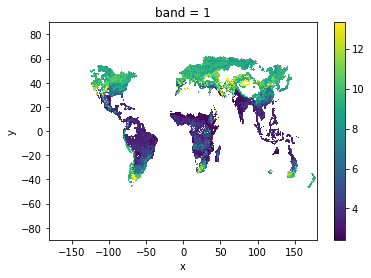

In [20]:
with xr.open_rasterio(data_path / "maize_yieldpotential.tif") as ypottif:
    ypottif = ypottif.where(ypottif > -1000) #.sel(x=slice(-30,60), y=slice(40, -50))
    ypottif.plot();

In [21]:
# find valid data, searches surrounding pixels for given distances until
# it findes valid data (up to a distance of 1.5 degrees)

def find_valid(df, idx, row):
    value = df.loc[idx, "ypot"] = ypottif.sel(x=row.longitude, y=row.latitude, method='nearest').values
    if np.isnan(value):
        for eps in [0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1.0, 1.5]:
            for i, j in [(-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1), (-1,-1)]:
                LO, LA = i*eps, j*eps
                next_best = ypottif.sel(x=row.longitude+LO, y=row.latitude+LA, method='nearest').values
                if np.isnan(next_best) == False:
                    print(f"{idx} - found next best with eps={eps} in direction {(LO,LA)}")
                    df.loc[idx, "ypot"] = next_best
                    df.loc[idx, "ypot_dist"] = eps
                    return df
    else:
        df.loc[idx, "ypot"] = value
    return df

In [22]:
df["ypot"] = np.nan
df["ypot_dist"] = 0
for idx, row in df.iterrows():
    df = find_valid(df, idx, row)

df.to_csv("locations_with_ypot.csv")
df.head()

16 - found next best with eps=1.0 in direction (-1.0, 0.0)
18 - found next best with eps=0.025 in direction (-0.025, 0.0)
19 - found next best with eps=0.025 in direction (0.025, 0.025)


,no,latitude,longitude,ypot,ypot_dist
0,1,-17.583333,31.233333,6.728927,0.0
1,2,0.100000,34.550000,3.930862,0.0
2,3,0.000000,34.583333,5.224795,0.0
3,4,-1.250000,36.766667,6.259733,0.0
4,5,-17.700000,31.000000,7.086719,0.0
